# Final Project of Big Data & Automated Content Analysis
## Are Housewives More Depressed? A Text and Visual Emotion Detection Study Based on YouTube
## Part 2 Text and Visual Analysis
<br>
Student: Dongdong Zhu <br>
Student number: 13523171

Part 2 aims to explore the emotions related to videos of housewives on YouTube using both text analysis with the BOW approach and visual analysis with the CNN approach. It will take around 30 minutes to run this script.

## 0. Install and import packages

In [1]:
!pip install wordninja

In [2]:
!pip install pytube

In [3]:
#import general packages
import argparse
import csv
import json
import nltk
import numpy as np
import os
import pandas as pd
import re
import spacy
import string
import sys

from matplotlib import pyplot as plt
from scipy.stats import f_oneway
from scipy import stats

In [4]:
#import packages for text analysis
from glob import glob
from sklearn import preprocessing, metrics
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import (cross_val_score,train_test_split,GridSearchCV)
from sklearn.metrics import (confusion_matrix,classification_report,roc_curve,
                             auc,cohen_kappa_score,make_scorer,f1_score)
from sklearn.naive_bayes import (MultinomialNB, GaussianNB)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.similarities import SoftCosineSimilarity, SparseTermSimilarityMatrix, WordEmbeddingSimilarityIndex
from gensim.corpora import Dictionary

import wordninja
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/zhuzhu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zhuzhu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zhuzhu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhuzhu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/zhuzhu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
#import packages for visual analysis
from pytube import YouTube

import cv2
import time
import uuid
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.models import save_model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers import BatchNormalization
from keras import backend as K

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-05-31 22:42:29.702359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
da_housewife = pd.read_csv("transcripts_housewife.csv").dropna()
da_housewife = da_housewife[da_housewife["transcript"] != "None"]
da_housewife.shape

(258, 2)

In [7]:
da_career = pd.read_csv("transcripts_career.csv").dropna()
da_career = da_career[da_career["transcript"] != "None"]
da_career.shape

(366, 2)

In [8]:
da_vlog = pd.read_csv("transcripts_vlog.csv").dropna()
da_vlog = da_vlog[da_vlog["transcript"] != "None"]
da_vlog.shape

(196, 2)

In [9]:
da_housewife.head()

,video_id,transcript
7,8zR6SlxBH-E,[Music] super again [Music] for spicy
8,hDJ6IHRcNM0,again for spicy
11,8de_2Tbrz14,"so if I'm a soccer mom with a spare $200,000 h..."
13,GjP_dtup0CI,[Music] it's the simple things it's the energy
17,zlynun6HedQ,Good morning It's windy today It's a comfortab...


## 2. Text Analysis with supervised machine learning

### 2.1 Pre-process texts

The code in this part was copied from: <br>
https://github.com/iremhttp/DepressionDetection/blob/main/main.ipynb

In [10]:
#map a POS tag for lemmatization
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # adjective
    elif tag.startswith('V'):
        return 'v'  # verb
    elif tag.startswith('N'):
        return 'n'  # noun
    elif tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # default to noun if not found

In [11]:
#define a function to preprocess texts
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    text = text.lower()

    #remove characters and symbols
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    contractions = {
        "aint": "is not", "arent": "are not","cant": "can not",
        "cause": "because", "couldve": "could have", "couldnt": "could not",
        "didnt": "did not",  "doesnt": "does not", "dont": "do not", "hadnt": "had not",
        "hasnt": "has not", "havent": "have not", "hed": "he would", "hes": "he is",
        "howd": "how did", "howll": "how will", "hows": "how is",  "I'd": "I would",
        "I'd've": "I would have", "Ill": "I will",  "Ill've": "I will have","Im": "I am", "I've": "I have",
        "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "im": "i am" , "i'll've": "i will have","i'm": "i am",
        "i've": "i have", "isnt": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
        "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
        "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
        "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
        "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
        "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
        "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have",
        "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
        "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
        "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
        "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
        "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
        "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
        "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is",
        "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
        "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
        "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
        "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
        "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
        "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
        "you're": "you are", "you've": "you have"

    }

    #replace contractions
    for contraction, expanded_form in contractions.items():
        text = text.replace(contraction, expanded_form)

    #tokenize the text into words using wordninja
    tokens = wordninja.split(text)

    #perform POS tagging
    pos_tags = pos_tag(tokens)

    #lemmatization
    lemmatized_tokens = []
    for word, tag in pos_tags:
        pos = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_tokens.append(lemma)

    #remove stop words
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]

     #remove duplicate words
    unique_tokens = []
    for word in filtered_tokens:
        if word not in unique_tokens:
            unique_tokens.append(word)

    #recreate text from unique tokens
    filtered_text = ' '.join(unique_tokens)

    return filtered_text

In [12]:
#preprocess transcripts of each dataset
da_housewife["processed_transcript"] = da_housewife["transcript"].apply(preprocess_text)
da_career["processed_transcript"] = da_career["transcript"].apply(preprocess_text)
da_vlog["processed_transcript"] = da_vlog["transcript"].apply(preprocess_text)

In [13]:
da_housewife.head()

,video_id,transcript,processed_transcript
7,8zR6SlxBH-E,[Music] super again [Music] for spicy,music super spicy
8,hDJ6IHRcNM0,again for spicy,spicy
11,8de_2Tbrz14,"so if I'm a soccer mom with a spare $200,000 h...",soccer mom spare much trunk space talk probabl...
13,GjP_dtup0CI,[Music] it's the simple things it's the energy,music si ample thing energy
17,zlynun6HedQ,Good morning It's windy today It's a comfortab...,good morning windy today comfortable holiday p...


### 2.2 Label data

In this part, a labeled dataset of depression detection was downloaded from: <br>
https://github.com/iremhttp/DepressionDetection/blob/main/main.ipynb <br>
It contains 27 thousand texts labeled as 1 or 0 to detect whether the texts were depressed or not.

In [14]:
labeled = pd.read_csv("mental_health.csv")
labeled.shape

(27977, 2)

In [15]:
labeled.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [16]:
labeled["label"].value_counts()

0    14139
1    13838
Name: label, dtype: int64

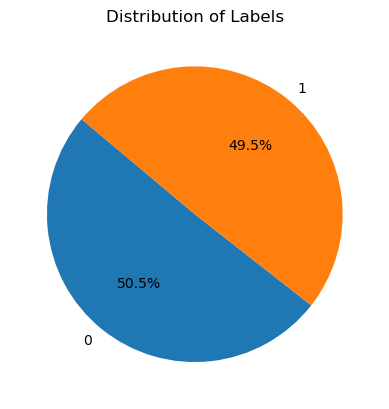

In [17]:
#check if the labeled dataset is balanced or not
#the code in this cell was copied from https://github.com/iremhttp/DepressionDetection/blob/main/main.ipynb
labels = labeled["label"].value_counts()

plt.pie(labels, labels = labels.index, autopct="%1.1f%%", startangle = 140)
plt.title("Distribution of Labels")
plt.show()

In [18]:
#preprocess the labeled texts
labeled["preprocessed_text"] = labeled["text"].apply(preprocess_text)
labeled.head()

,text,label,preprocessed_text
0,dear american teens question dutch person hear...,0,dear american teen question dutch person hear ...
1,nothing look forward lifei dont many reasons k...,1,nothing look forward life many reason keep go ...
2,music recommendations im looking expand playli...,0,music recommendation look expand playlist usua...
3,im done trying feel betterthe reason im still ...,1,try feel better reason still alive know mum de...
4,worried year old girl subject domestic physic...,1,worried year old girl subject domestic physica...


### 2.2 Use BOW approach

In this part, the BOW approach will be used to do the text analysis.
The code in this part follows: <br>
https://github.com/uvacw/teaching-bdaca/blob/main/modules/machinelearning-text-exercises/solutions/exercise2-possible-solution.md <br>
and https://cssbook.net/content/chapter11.html#sec-bestclassifier .

In [19]:
#define a function to get the labeled data
def get_labeled_data(fn):
    text = fn.iloc[:, 2].tolist()
    label = fn.iloc[:, 1].tolist()
    return text,label

texts, labels = get_labeled_data(labeled)

#split the data into trainning, validation and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"We have {len(X_train)} train examples, and {len(X_val)} validation examples, and {len(X_test)} test examples.")

We have 16785 train examples, and 5596 validation examples, and 5596 test examples.


In [20]:
#compare the performance of different classifiers with both CountVectorizer and TfidVectorizer
configurations = [('NB with Count', CountVectorizer(min_df=5, max_df=.5), MultinomialNB()),
                 ('NB with TfIdf', TfidfVectorizer(min_df=5, max_df=.5), MultinomialNB()),
                 ('LogReg with Count', CountVectorizer(min_df=5, max_df=.5), LogisticRegression(solver='liblinear')),
                 ('LogReg with TfIdf', TfidfVectorizer(min_df=5, max_df=.5), LogisticRegression(solver='liblinear')),
                 ('SVM with Count - linear kernel', CountVectorizer(min_df=5, max_df=.5), SVC(kernel='linear')),
                 ('SVM with Tfidf - linear kernel', TfidfVectorizer(min_df=5, max_df=.5), SVC(kernel='linear')),
                 ]

for description, vectorizer, classifier in configurations:
    print(description)
    pipe = make_pipeline(vectorizer, classifier)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    print(metrics.classification_report(y_val, y_pred))
    print("\n")

NB with Count
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      2830
           1       0.80      0.97      0.87      2766

    accuracy                           0.86      5596
   macro avg       0.88      0.86      0.86      5596
weighted avg       0.88      0.86      0.86      5596



NB with TfIdf
              precision    recall  f1-score   support

           0       0.95      0.79      0.87      2830
           1       0.82      0.96      0.88      2766

    accuracy                           0.88      5596
   macro avg       0.89      0.88      0.88      5596
weighted avg       0.89      0.88      0.88      5596



LogReg with Count
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2830
           1       0.93      0.89      0.91      2766

    accuracy                           0.91      5596
   macro avg       0.91      0.91      0.91      5596
weighted avg       0.91 

In [21]:
#use grid search to tune LogReg with TfIdf
pipeline_LogRegwithTfIdf = Pipeline(
    steps = [
         ("vectorizer", TfidfVectorizer()),
         ("classifier", LogisticRegression()),
     ]
 )
grid = {
     "vectorizer__ngram_range": [(1, 1), (1, 2)],
     "vectorizer__max_df": [0.5, 1.0],
     "vectorizer__min_df": [0, 5],
 }
search = GridSearchCV(
     estimator = pipeline_LogRegwithTfIdf,
     n_jobs = -1,
     param_grid = grid,
     scoring = "accuracy",
     cv = 5
 )
search.fit(X_train, y_train)

print(f"Best parameters for LogReg with TfIdf: {search.best_params_} ")

pred = search.predict(X_val)
print(metrics.classification_report(y_val, pred))

Best parameters for LogReg with TfIdf: {'vectorizer__max_df': 0.5, 'vectorizer__min_df': 5, 'vectorizer__ngram_range': (1, 2)} 
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2830
           1       0.93      0.92      0.92      2766

    accuracy                           0.92      5596
   macro avg       0.92      0.92      0.92      5596
weighted avg       0.92      0.92      0.92      5596



In [22]:
#print the final classification report using LogReg with TfIdf as it has the best performance
myvec = TfidfVectorizer(min_df=5, max_df=0.5)
myclf = LogisticRegression()

pipe = make_pipeline(myvec, myclf)
pipe.fit(X_train, y_train)
y_pred_final = pipe.predict(X_test)
print(metrics.classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2802
           1       0.93      0.91      0.92      2794

    accuracy                           0.92      5596
   macro avg       0.92      0.92      0.92      5596
weighted avg       0.92      0.92      0.92      5596



In [23]:
#define a function to get unlabeled data
def get_unlabeled_data(fi):
    return fi.iloc[:, 2].tolist()

In [24]:
#define a function to predict the unlabeled data
def get_predictions(df, vectorizer, classifier, X_train, y_train):
    unlabeled_data = get_unlabeled_data(df)

    X_tr = vectorizer.fit_transform(X_train)
    X_unlabeled = vectorizer.transform(unlabeled_data)
    classifier.fit(X_tr, y_train)

    y_pred = classifier.predict(X_unlabeled)
    return y_pred

vectorizer = TfidfVectorizer(min_df=5, max_df=0.5)
classifier = LogisticRegression()

#predict the unlabeled dataset respectively
y_pred_housewife = get_predictions(da_housewife, vectorizer, classifier, X_train, y_train)
y_pred_career = get_predictions(da_career, vectorizer, classifier, X_train, y_train)
y_pred_vlog = get_predictions(da_vlog, vectorizer, classifier, X_train, y_train)

In [25]:
da_housewife["labels"] = y_pred_housewife
da_housewife.head()

,video_id,transcript,processed_transcript,labels
7,8zR6SlxBH-E,[Music] super again [Music] for spicy,music super spicy,0
8,hDJ6IHRcNM0,again for spicy,spicy,0
11,8de_2Tbrz14,"so if I'm a soccer mom with a spare $200,000 h...",soccer mom spare much trunk space talk probabl...,0
13,GjP_dtup0CI,[Music] it's the simple things it's the energy,music si ample thing energy,0
17,zlynun6HedQ,Good morning It's windy today It's a comfortab...,good morning windy today comfortable holiday p...,0


In [26]:
da_career["labels"] = y_pred_career
da_career.head()

,video_id,transcript,processed_transcript,labels
1,wUq8s9WyKMU,which is true but are you working towards that...,true work towards something yeah know car drea...,0
2,FTXelgD2GT0,[Music] uh baby here you are what is going on ...,music uh baby go tell dinner ered like minute ...,1
3,1gfN87SHBjQ,if you think being busy is just an excuse meet...,think busy excuse meet jenna juggle task smile...,0
4,VItmkAYYA4o,this message is for everyone who believes that...,message everyone believe manager ruin life cou...,1
5,-Rlv7iKAffM,I do think that there are some women who just ...,think woman want work option c uz mean somebod...,1


In [27]:
da_vlog["labels"] = y_pred_vlog
da_vlog.head()

,video_id,transcript,processed_transcript,labels
10,_kS57AF8C5M,My study abroad is finally over and I am retur...,study abroad finally return japan first ti yea...,1
26,qfnf3S7JyVA,what's up boss how Kev yes how you do I just g...,bos kev yes get fw jersey boy adam aka cowboy ...,0
29,5y5c7PvFJ-A,all right I just made the craziest fold sha De...,right make crazy fold sha dee say bad ever see...,0
43,6r_39Sng3kg,"Good morning, everyone. Welcome back to my hom...",good morning everyone welcome back home v log ...,0
55,hLZaxrz2ePA,hey it's SM back on YouTube video and as y see...,hey sm back youtube video see title today get ...,0


In [28]:
#save the labeled datasets respectively
da_housewife.to_csv("predictions_housewife.csv", index = False)
da_career.to_csv("predictions_career.csv", index = False)
da_vlog.to_csv("predictions_vlog.csv", index = False)

### 2.3 Data analysis

In this part, a one-way ANOVA test was conducted.
The null hypothesis is that the levels of depression detection among the group of housewives, career woman and regular vlogs are equal.

In [29]:
da_housewife["labels"].value_counts()

0    216
1     42
Name: labels, dtype: int64

In [30]:
da_career["labels"].value_counts()

0    229
1    137
Name: labels, dtype: int64

In [31]:
da_vlog["labels"].value_counts()

0    179
1     17
Name: labels, dtype: int64

In [32]:
mean_housewife = round(np.mean(da_housewife["labels"]), 2)
sd_housewife = round(np.std(da_housewife["labels"]), 2)

mean_career = round(np.mean(da_career["labels"]), 2)
sd_career = round(np.std(da_career["labels"]), 2)

mean_vlog = round(np.mean(da_vlog["labels"]), 2)
sd_vlog = round(np.std(da_vlog["labels"]), 2)

In [33]:
#perform one-way ANOVA test
alpha = 0.05

F_statistic, p_value = f_oneway(da_housewife["labels"], da_career["labels"], da_vlog["labels"])

F_statistic = round(F_statistic,4)
p_value = round(p_value,4)

if p_value < alpha:
    print(f"Based on this ANOVA test, there is a statistically significant differences among the depression level of"
          f"the group of housewives (M = {mean_housewife}, SD = {sd_housewife}), career women (M = {mean_career}, SD = {sd_career}),"
          f"and daily vlogs(M = {mean_vlog}, SD = {sd_vlog}), F = {F_statistic}, p = {p_value}."
          "Therefore, the null hypothesis can be rejected.")
else:
    print(f"Based on this ANOVA test, there is no statistically significant differences among the depression level of"
          f"the group of housewives (M = {mean_housewife}, SD = {sd_housewife}), career women (M = {mean_career}, SD = {sd_career}),"
          f"and daily vlogs(M = {mean_vlog}, SD = {sd_vlog}), F = {F_statistic}, p = {p_value}."
          "Therefore, the null hypothesis can be retained.")

Based on this ANOVA test, there is a statistically significant differences among the depression level ofthe group of housewives (M = 0.16, SD = 0.37), career women (M = 0.37, SD = 0.48),and daily vlogs(M = 0.09, SD = 0.28), F = 38.1657, p = 0.0.Therefore, the null hypothesis can be rejected.


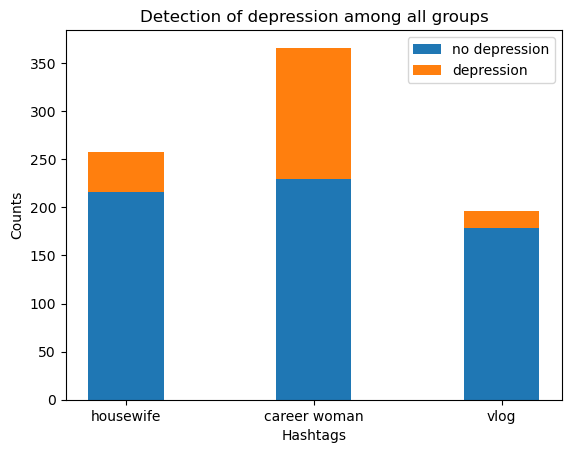

In [34]:
#visualize the depression predictions
#the code in this cell was adapted from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
#and https://stackoverflow.com/questions/56076590/plotting-multiple-bars-with-matplotlib-using-ax-bar

housewife_counts = da_housewife['labels'].value_counts().sort_index()
career_counts = da_career['labels'].value_counts().sort_index()
vlog_counts = da_vlog['labels'].value_counts().sort_index()

counts_0 = [housewife_counts[0], career_counts[0], vlog_counts[0]]
counts_1 = [housewife_counts[1], career_counts[1], vlog_counts[1]]

label_list = ["housewife", "career woman", "vlog"]

fig, ax = plt.subplots()
bar_width = 0.4

bar0 = ax.bar(label_list, counts_0, bar_width, label = 'no depression')
bar1 = ax.bar(label_list, counts_1, bar_width, bottom = counts_0, label = 'depression')

plt.title("Detection of depression among all groups")
plt.xlabel("Hashtags")
plt.ylabel("Counts")
plt.legend()
plt.show()

## 3. Visual analysis

In this part, a visual analysis to detect emotions in videos was conducted. First, images of human faces were identified and downloaded as new files from the videos. Then, a facial expression model using CNN was used to identify the emotions of each face shot.
<br>
Due to limitations in computational resources, this part was not scaled up and only detected around 10 videos. However, the code proved that it is feasible.

### 3.1 Collect faceshots from videos

In [35]:
#use videos from the hashtag og housewife as a sample
videoid = pd.read_csv("video_ids_housewife.csv")
videoid.head()

,video_id,url
0,XDa9aoFhggE,https://www.youtube.com/watch?v=XDa9aoFhggE
1,kx9absNabic,https://www.youtube.com/watch?v=kx9absNabic
2,X8Yc7HgOBn4,https://www.youtube.com/watch?v=X8Yc7HgOBn4
3,XSoDA-aQemY,https://www.youtube.com/watch?v=XSoDA-aQemY
4,KTuAQxp9IHQ,https://www.youtube.com/watch?v=KTuAQxp9IHQ


In [36]:
#download 10 videos from the dataset
#The code in this cell was adapted from: https://github.com/pytube/pytube
os.makedirs("videos", exist_ok=True)

urls = videoid["url"].head(10)

for url in urls:
    try:
        yt = YouTube(url)
        stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
        stream.download("videos")
        print(f"Video was downloaded from {url}.")
    except Exception as e:
        print(f"Video cannot be downloaded from {url}: {e}.")

Video was downloaded from https://www.youtube.com/watch?v=XDa9aoFhggE.
Video was downloaded from https://www.youtube.com/watch?v=kx9absNabic.
Video was downloaded from https://www.youtube.com/watch?v=X8Yc7HgOBn4.
Video cannot be downloaded from https://www.youtube.com/watch?v=XSoDA-aQemY: 'NoneType' object has no attribute 'download'.
Video was downloaded from https://www.youtube.com/watch?v=KTuAQxp9IHQ.
Video cannot be downloaded from https://www.youtube.com/watch?v=g0D2YVYprhs: g0D2YVYprhs is age restricted, and can't be accessed without logging in..
Video cannot be downloaded from https://www.youtube.com/watch?v=JeMIY2ELKAY: JeMIY2ELKAY is age restricted, and can't be accessed without logging in..
Video cannot be downloaded from https://www.youtube.com/watch?v=8zR6SlxBH-E: 8zR6SlxBH-E is age restricted, and can't be accessed without logging in..
Video was downloaded from https://www.youtube.com/watch?v=hDJ6IHRcNM0.
Video was downloaded from https://www.youtube.com/watch?v=IKAbTQ6YmU

In [ ]:
#define a function to identify humans' face and download pictures
#The code in this cell was copied from: https://github.com/Smarangk13/youtubeFaceFinder/blob/master/faceshot.py
#The file 'face.xml' was also downloaded from: https://github.com/Smarangk13/youtubeFaceFinder/blob/master/faceshot.py
class FaceFinder:
    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier('face.xml')

    def isFaceVideo(self, video_path, facesNeed=5, sleeptime=5):
        cap = cv2.VideoCapture(video_path)
        print("Opened Video:", video_path)

        faceFound = 0
        while(cap.isOpened()):
            ret, frame = cap.read()
            if not ret:
                break

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = self.face_cascade.detectMultiScale(gray, 1.1, 5)

            for (x, y, w, h) in faces:
                faceFound += 1
                filename = f"faceshot/face_{uuid.uuid4()}.jpeg"
                cv2.imwrite(filename, frame[y:y+h, x:x+w])
                print("Face Found:", filename)
                time.sleep(sleeptime)

                if faceFound >= facesNeed:
                    cap.release()
                    cv2.destroyAllWindows()
                    return

        cap.release()
        cv2.destroyAllWindows()
        return

if __name__ == "__main__":
    face_finder = FaceFinder()
    videos_folder = "videos"
    faces_folder = "faceshot"

    os.makedirs(faces_folder, exist_ok=True)

    for filename in os.listdir(videos_folder):
        if filename.endswith(".mp4") or filename.endswith(".avi") or filename.endswith(".webm"):
            video_path = os.path.join(videos_folder, filename)
            face_finder.isFaceVideo(video_path)


### 3.2 Facial expression detection using CNN

In this part, CNN was used to detect the facial expressions of the faceshots collected from the video dataset of housewives. <br>
The labeled dataset "fer2013.csv" was downloaded from: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data <br>
However, due to the limitations of GPU and time, this part did not use the completed labeled dataset but instead a shortened version "fer2013_shortened_300.csv" downloaded from: https://github.com/patryk-oleniuk/emotion_recognition/blob/master/emotion_recognition_Oleniuk_Galotta_v2.ipynb <br>
The code in this part was adapted from: https://www.kaggle.com/code/shawon10/facial-expression-detection-cnn/notebook

In [38]:
#get the data
#to use the completed train dataset, please replace filename by 'fer2013.csv'
filename = 'fer2013_shortened_300.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names =['emotion','pixels','usage']
df = pd.read_csv(filename, names  =names, na_filter=False)
im = df['pixels']
df.head()

,emotion,pixels,usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [39]:
df.shape

(300, 3)

In [40]:
#read image data and labels
def getData(filename):
    Y = []
    X = []
    first = True
    for line in open(filename):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [41]:
X, Y = getData(filename)
num_class = len(set(Y))
print(num_class)

7


In [42]:
#calculate the shape of the array and reshape it
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [43]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [44]:
#define a CNN model to classify images
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

    return model
model=my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       4

In [ ]:
path_model = 'model_filter.h5'  #save model at this location after each epoch
keras.backend.clear_session()  #destroys the current graph and builds a new one
model = my_model()  # create the model
K.set_value(model.optimizer.lr, 1e-3)  #set the learning rate

#fit the model
h = model.fit(x=X_train,
              y=y_train,
              batch_size=64,
              epochs=20,
              verbose=1,
              validation_data=(X_test, y_test),
              shuffle=True,
              callbacks=[
                  ModelCheckpoint(filepath=path_model),
              ]
              )

#save the model
save_model(model, 'my_model.keras')

Epoch 1/20
2/5 [===========>..................] - ETA: 6s - loss: 2.3354 - accuracy: 0.1875 

In [ ]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

In [ ]:
y_pred = model.predict(X_test)
y_test.shape

In [ ]:
#predict the emotions of pictures in the file of faceshot
def predict_emotion(model, img_path):
    img = image.load_img(img_path, color_mode="grayscale", target_size=(48, 48))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0

    custom = model.predict(x)
    emotion_index = np.argmax(custom[0])

    return emotion_index

model = my_model()
folder_path = 'faceshot'
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotion_counts = {label: 0 for label in emotion_labels}

#count the number of each predicted emotion
for filename in os.listdir(folder_path):
    if filename.endswith('.jpeg'):
        img_path = os.path.join(folder_path, filename)
        emotion_index = predict_emotion(model, img_path)
        predicted_emotion = emotion_labels[emotion_index]
        emotion_counts[predicted_emotion] += 1

#calculate and print the percentage of each predicted emotion
total_images = sum(emotion_counts.values())
for emotion_label in emotion_labels:
    if total_images > 0:
        percentage = round(emotion_counts[emotion_label] / total_images * 100, 3)
        print(f"Based on the predictions, {percentage}% of the faceshots were predicted as {emotion_label}.")
    else:
        print(f"No images found in the folder {folder_path}.")
